In [1]:
import numpy as np
import pandas as pd

import cv2
from pathlib import Path

import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.feature import local_binary_pattern

import os, glob, random



In [2]:
def get_rgb(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def get_hsv(path):
    img = cv2.imread(path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return hsv

def get_gray(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

def get_green_coverage(img_):
    green_mask = (img_[:, :, 1] > img_[:, :, 0]) & (img_[:, :, 1] > img_[:, :, 2])
    return green_mask.sum() / green_mask.size

def get_sobel(gray_, ksize = 3):
    sobelx  = cv2.Sobel(gray_, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely  = cv2.Sobel(gray_, cv2.CV_64F, 0, 1, ksize=ksize)
    return np.sqrt(sobelx**2 + sobely**2)

def get_canny(gray_, low_threshold = 100, high_threshold = 200): 
    return cv2.Canny(gray_, low_threshold, high_threshold) 
    
def get_binary(gray, threshold = 127):
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    return binary 
 
def get_lbp(gray_, p = 8, r = 3, method = "uniform"):
    return local_binary_pattern(gray_, P=p, R=r, method=method)

def get_contours(binary):
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [3]:
def update_features(path_):

    all_features = {}

    all_features.update(get_rgb_hsv_features(path_))
    all_features.update(get_texture_features(path_))

    return all_features


def get_rgb_hsv_features(path_):
    features = {}

    rgb_img = get_rgb(path_)
    hsv_img = get_hsv(path_)

    for i , channel in enumerate(['r', 'g', 'b']):
        features[f'{channel}_mean']     = rgb_img[:, :, i].mean()
        features[f'{channel}_median']   = np.median(rgb_img[:, :, i])
        features[f'{channel}_std']      = rgb_img[:, :, i].std()
    
    features['green_coverage'] = get_green_coverage(rgb_img); del rgb_img

    for i , channel in enumerate(['hue', 'sat', 'val']):
        features[f'{channel}_mean']     = hsv_img[:, :, i].mean()
        features[f'{channel}_std']      = hsv_img[:, :, i].std()
    
    del hsv_img    
    return features     

def get_texture_features(path_):
    features = {}

    gray_img    = get_gray(path_)
    sobel_img   = get_sobel(gray_img)
    canny_img   = get_canny(gray_img)
    binary_img  = get_binary(gray_img)
    lbp_img     = get_lbp(gray_img)

    features['sobel_mean']  = sobel_img.mean()
    features['sobel_std']   = sobel_img.std(); del sobel_img

    features['canny_mean']  = canny_img.mean()
    features['canny_std']   = canny_img.std(); del canny_img

    features['binary_mean'] = binary_img.mean()
    features['binary_std']  = binary_img.std(); del binary_img
 
    features['lbp_mean']    = lbp_img.mean()
    features['lbp_std']     = lbp_img.std(); del lbp_img

    return features


In [4]:
project_path = "/Users/k.choi/Documents/github/csiro_git"
data_path   = os.path.join(project_path, "data")
img_path    = os.path.join(data_path, "train")
img_list    = glob.glob(os.path.join(img_path, "*.jpg"))
train_df    = pd.read_csv(os.path.join(data_path, "train.csv"))
train_df['image_id'] = train_df['image_path'].apply(lambda x: Path(x).stem)

print('project_path : ', project_path)
print('data_path : ', data_path)
print('img_path : ', img_path)
print('total number of images : ', len(img_list))
print('train_df : ', train_df.info())

project_path :  /Users/k.choi/Documents/github/csiro_git
data_path :  /Users/k.choi/Documents/github/csiro_git/data
img_path :  /Users/k.choi/Documents/github/csiro_git/data/train
total number of images :  357
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_id      1785 non-null   object 
 1   image_path     1785 non-null   object 
 2   Sampling_Date  1785 non-null   object 
 3   State          1785 non-null   object 
 4   Species        1785 non-null   object 
 5   Pre_GSHH_NDVI  1785 non-null   float64
 6   Height_Ave_cm  1785 non-null   float64
 7   target_name    1785 non-null   object 
 8   target         1785 non-null   float64
 9   image_id       1785 non-null   object 
dtypes: float64(3), object(7)
memory usage: 139.6+ KB
train_df :  None


/Users/k.choi/Documents/github/csiro_git/data/train/ID2003438517.jpg


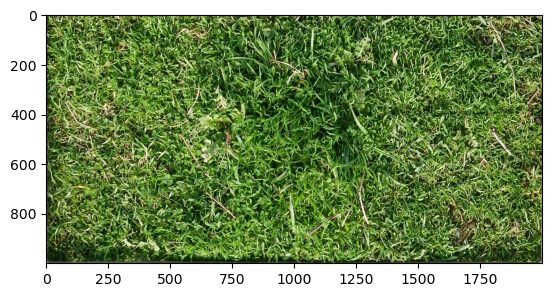

/Users/k.choi/Documents/github/csiro_git/data/train/ID384648061.jpg


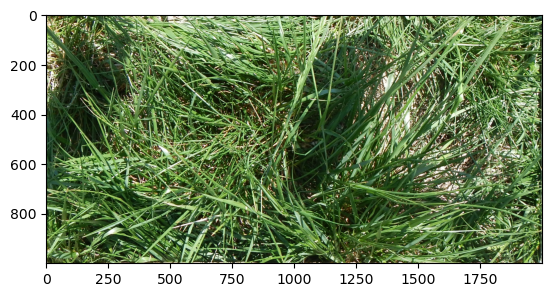

/Users/k.choi/Documents/github/csiro_git/data/train/ID325799913.jpg


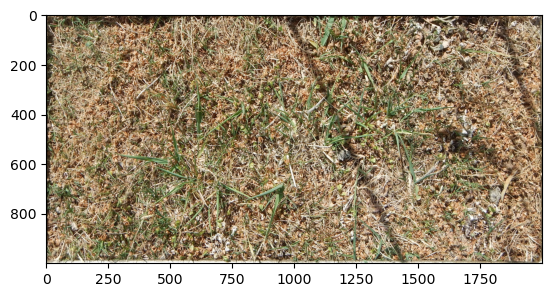

In [24]:
selected_img_path = random.sample(img_list, 7)

for img_path in selected_img_path[:3]:
    print(img_path)
    rgb_img = get_rgb(img_path)
    plt.imshow(rgb_img)
    plt.show()

In [6]:
features_list = []

for img_path in tqdm(selected_img_path):

    try:
        features = update_features(img_path)
    
        features['image_id'] = Path(img_path).stem

        features_list.append(features)

    except Exception as e:
        print(f"Error loading {img_path}: {e}")
        continue

features_df = pd.DataFrame(features_list)
cols = ['image_id'] + [ col for col in features_df.columns if col != 'image_id' ]
features_df = features_df[cols]




100%|██████████| 7/7 [00:01<00:00,  3.72it/s]


In [7]:
metadata_df = train_df.groupby('image_id').first()[['Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm']].reset_index()

metadata_df = pd.merge(features_df, metadata_df, on='image_id', how='left')

metadata_df.info()
 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_id        7 non-null      object 
 1   r_mean          7 non-null      float64
 2   r_median        7 non-null      float64
 3   r_std           7 non-null      float64
 4   g_mean          7 non-null      float64
 5   g_median        7 non-null      float64
 6   g_std           7 non-null      float64
 7   b_mean          7 non-null      float64
 8   b_median        7 non-null      float64
 9   b_std           7 non-null      float64
 10  green_coverage  7 non-null      float64
 11  hue_mean        7 non-null      float64
 12  hue_std         7 non-null      float64
 13  sat_mean        7 non-null      float64
 14  sat_std         7 non-null      float64
 15  val_mean        7 non-null      float64
 16  val_std         7 non-null      float64
 17  sobel_mean      7 non-null      float64

In [21]:
dry_df      = train_df[train_df['target_name'] == 'Dry_Total_g'][['image_id', 'target']].copy(); print(len(dry_df))
green_df    = train_df[train_df['target_name'] == 'Dry_Green_g'][['image_id', 'target']].copy(); print(len(green_df))
dead_df     = train_df[train_df['target_name'] == 'Dry_Dead_g'][['image_id', 'target']].copy(); print(len(dead_df))
clover_df   = train_df[train_df['target_name'] == 'Dry_Clover_g'][['image_id', 'target']].copy(); print(len(clover_df))
gdm_df      = train_df[train_df['target_name'] == 'GDM_g'][['image_id', 'target']].copy(); print(len(gdm_df))


dry_df      = dry_df.rename(columns={'target': 'Dry_Total_g'})
green_df    = green_df.rename(columns={'target': 'Dry_Green_g'})
dead_df     = dead_df.rename(columns={'target': 'Dry_Dead_g'})
clover_df   = clover_df.rename(columns={'target': 'Dry_Clover_g'})
gdm_df      = gdm_df.rename(columns={'target': 'GDM_g'})

complete_df = pd.merge(metadata_df, dry_df, on='image_id')
complete_df = pd.merge(complete_df, green_df, on='image_id')
complete_df = pd.merge(complete_df, dead_df, on='image_id')
complete_df = pd.merge(complete_df, clover_df, on='image_id')
complete_df = pd.merge(complete_df, gdm_df, on='image_id')

print(complete_df.columns)
print(complete_df.info())


357
357
357
357
357
Index(['image_id', 'r_mean', 'r_median', 'r_std', 'g_mean', 'g_median',
       'g_std', 'b_mean', 'b_median', 'b_std', 'green_coverage', 'hue_mean',
       'hue_std', 'sat_mean', 'sat_std', 'val_mean', 'val_std', 'sobel_mean',
       'sobel_std', 'canny_mean', 'canny_std', 'binary_mean', 'binary_std',
       'lbp_mean', 'lbp_std', 'Sampling_Date', 'State', 'Species',
       'Pre_GSHH_NDVI', 'Height_Ave_cm', 'Dry_Total_g', 'Dry_Green_g',
       'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_id        7 non-null      object 
 1   r_mean          7 non-null      float64
 2   r_median        7 non-null      float64
 3   r_std           7 non-null      float64
 4   g_mean          7 non-null      float64
 5   g_median        7 non-null      float64
 6   g_st

In [22]:
complete_df[:10]

,image_id,r_mean,r_median,r_std,g_mean,g_median,g_std,b_mean,b_median,b_std,...,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Total_g,Dry_Green_g,Dry_Dead_g,Dry_Clover_g,GDM_g
0,ID1620371305,112.714825,115.0,51.123808,151.578444,159.0,51.705472,56.460578,50.0,45.267383,...,2015/9/30,Vic,Phalaris_Clover,0.79,10.0000,80.5900,57.0895,6.4092,17.0913,74.1808
1,ID684383343,128.772140,121.0,64.748909,117.413733,108.0,66.129949,83.253508,69.0,64.235031,...,2015/10/14,Vic,Phalaris_Clover_Ryegrass_Barleygrass_Bromegrass,0.48,4.5000,47.8000,19.2877,16.7719,11.7404,31.0281
2,ID141370843,110.553661,106.0,59.050139,138.570368,137.0,57.493368,63.060964,53.0,53.378162,...,2015/8/14,Vic,Ryegrass_Clover,0.72,4.0000,30.9000,19.6636,5.6182,5.6182,25.2818
3,ID40849327,99.687414,82.0,62.516929,124.037768,115.0,59.366976,75.148669,65.0,53.105309,...,2015/8/21,WA,Clover,0.81,4.0000,51.9700,0.0000,0.0000,51.9700,51.9700
4,ID249042826,115.748293,110.0,68.947968,118.991188,116.0,65.644939,75.757939,63.0,60.923917,...,2015/9/4,Tas,Clover,0.53,2.8333,16.3385,1.8000,3.8769,10.6616,12.4615
5,ID1062837331,107.319376,114.0,52.037572,153.111213,165.0,53.210209,58.102050,57.0,43.116386,...,2015/9/29,Vic,Ryegrass_Clover,0.82,9.0000,59.3500,35.4077,3.9623,19.9800,55.3877
6,ID1857489997,110.862048,104.0,62.691738,136.269651,135.0,63.201506,57.948934,42.0,56.428144,...,2015/7/1,Vic,Phalaris_Clover,0.66,3.0000,18.0000,13.3043,2.3478,2.3478,15.6522
